# Thomas Kiely: Etivity 5
## 17185203

E-tivity 5 builds on top of E-tivity 4 by introducing dimensionality reduction into the process of training and comparing predictive models (i.e., classification and regression models)

### Task 2
Repeat the experiment in Lab5 - Regression and Dimensionality Reduction.ipynb with the insurance.csv and draw conclusions from the results you observe in a markdown cell.

### Task 3
Add two dimensionality-reduction methods which are not used in Lab5 - Regression and Dimensionality Reduction.ipynb to the training pipelines. Aim at dimensionality reduction techniques which are sufficiently different from the ones used in the example notebook.

### Task 4
Experiment with a third regression algorithm. Describe how it compares to Random Forest and Linear regression in a markdown cell.

In [144]:
# Import required packages
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA 
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import RFE
from sklearn import svm
from sklearn import cluster
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import NeighborhoodComponentsAnalysis

# regression algorithms
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor
# metrics for evaluating regression models
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## EDA

In [145]:
df = pd.read_csv("./insurance-1.csv")
df.head()

,age,gender,bmi,children,smoker,region,insurance_cost
0,18,male,33.770,1,no,southeast,1725.55230
1,18,male,34.100,0,no,southeast,1137.01100
2,18,female,26.315,0,no,northeast,2198.18985
3,18,female,38.665,2,no,northeast,3393.35635
4,18,female,35.625,0,no,northeast,2211.13075


In [146]:
df.tail()

,age,gender,bmi,children,smoker,region,insurance_cost
1333,64,female,31.825,2,no,northeast,16069.08475
1334,64,female,26.885,0,yes,northwest,29330.98315
1335,64,male,26.410,0,no,northeast,14394.55790
1336,64,male,36.960,2,yes,southeast,49577.66240
1337,64,male,23.760,0,yes,southeast,26926.51440


In [147]:
df['insurance_cost'].value_counts()

1639.56310     2
8825.08600     1
4837.58230     1
3172.01800     1
12646.20700    1
              ..
2719.27975     1
19539.24300    1
12269.68865    1
6117.49450     1
10959.33000    1
Name: insurance_cost, Length: 1337, dtype: int64

In [148]:
df.isna().sum()

age               0
gender            0
bmi               0
children          0
smoker            0
region            0
insurance_cost    0
dtype: int64

`df.isna().sum()` shows that there are no missing values in the dataset

In [149]:
df.describe()

,age,bmi,children,insurance_cost
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


The data appears normal with no errors or negative values here

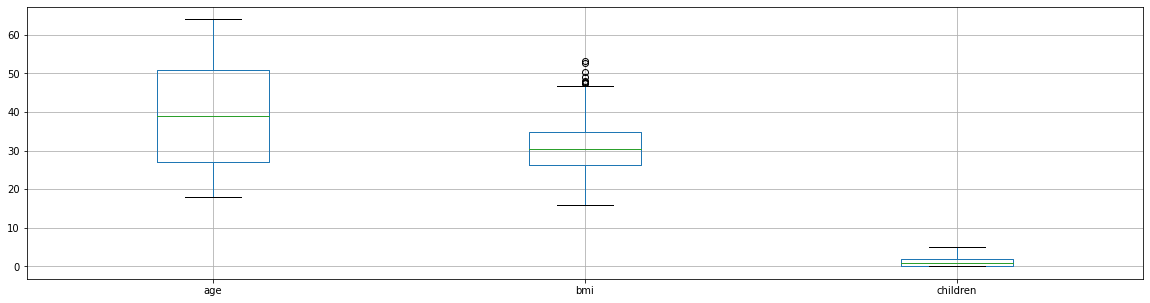

In [150]:
df.drop('insurance_cost', axis=1).boxplot(figsize=(20,5))
plt.show()

From the box plot above we can make some observations:
- `bmi` contains outliers
- neither `age` or `children` contain outliers
- `insurance_cost` was not included in the box plot as it is our target value and the large range of values could distort the view of other attributes

## Data Preparation 

First we will replace `gender`, `smoker` and `region` using one hot encoding, as these categorical attributes are not ordinal

In [152]:
df = pd.get_dummies(df, columns=['gender','smoker','region'], 
                        #dummy_na=True, 
                        drop_first=True)

In [153]:
df.head()

,age,bmi,children,insurance_cost,gender_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,18,33.770,1,1725.55230,1,0,0,1,0
1,18,34.100,0,1137.01100,1,0,0,1,0
2,18,26.315,0,2198.18985,0,0,0,0,0
3,18,38.665,2,3393.35635,0,0,0,0,0
4,18,35.625,0,2211.13075,0,0,0,0,0


In [154]:
df.tail()

,age,bmi,children,insurance_cost,gender_male,smoker_yes,region_northwest,region_southeast,region_southwest
1333,64,31.825,2,16069.08475,0,0,0,0,0
1334,64,26.885,0,29330.98315,0,1,1,0,0
1335,64,26.410,0,14394.55790,1,0,0,0,0
1336,64,36.960,2,49577.66240,1,1,0,1,0
1337,64,23.760,0,26926.51440,1,1,0,1,0


The categorical data has now been transformed into numerical attributes

In [155]:
# store a list with the names of all predictors
names_all = [c for c in df if c not in ['insurance_cost']]

# define column groups with same data preparation
names_outliers = ['bmi']
names_no_outliers = list(set(names_all) - set(names_outliers))

In the above cell we create a list from the outlier attributes (`bmi`), and a list for the others columns without outliers

A RobustScaler and log function will be applied to the outlier list

A StandardScaler will be applied to the other list

In [156]:
class AddColumnNames(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(data=X, columns=self.columns)

In [157]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X[self.columns]

In [158]:
preprocess_pipeline = make_pipeline(
    AddColumnNames(columns=names_all),
    FeatureUnion(transformer_list=[
        ("outlier_columns", make_pipeline(
            ColumnSelector(columns=names_outliers),
            FunctionTransformer(np.log, validate=True),
            RobustScaler()
        )),
        ("no_outlier_columns", make_pipeline(
            ColumnSelector(columns=names_no_outliers),
            StandardScaler()
        ))
    ])
)

Below, we split the target attribute, `insurance_cost` into  test and training sets, using an 80/20 split.

In [159]:
y = df['insurance_cost']
X = df.drop('insurance_cost', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

Next, we train `RandomForestRegressor` on the training set with a range of possible parameters in order to find the best parameters by cross-validation. To do this we will build another [main] pipeline which includes the preprocessing pipeline and `RandomForestRegressor`. We also add an element for dimensionality reduction after the preprocessing pipeline.

Here we will attempt three different dimensionality reduction methods and we will let the grid search pick the best one. These are:

- Principal Component Analysis (PCA)
- Recursive Feature Elimination (RFE) with estimator `svm.SVR`
- Recursive Feature Elimination (RFE) with estimator `LinearRegression`

- **Neighborhood Components Analysis**
- **Feature Agglomeration**

Note that RFE is using regression algorithms for selecting the best features. These regression algorithms can be different from the regression algorithm at the end of the main pipeline.

The main pipeline will take care for separately preprocessing the training and validation sets after the training set is further split into training and validation sets in the process of cross-validation. It also applies the dimensionality reduction method separately to the two sets.

**Random Forest pipeline**

In [160]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', RandomForestRegressor(n_estimators=10))])

In [161]:
N_FEATURES_OPTIONS = [2, 6, 11]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [NeighborhoodComponentsAnalysis(random_state=0)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
    }, 
    {
        'reduce_dim': [cluster.FeatureAgglomeration()],
        'reduce_dim__n_clusters': N_FEATURES_OPTIONS,
    }
    
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.859:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression(), n_features_to_select=11), 'reduce_dim__n_features_to_select': 11, 'regresson__max_depth': 4}


The parameter `refit=True` makes the `GridSearchCV` train a `RandomForestRegressor` model on the **whole training set** with the best parameters and the best dimensionality reduction method found. This best model can then be accessed via the `.best_estimator_` attribute of the `GridSearchCV`.

The CV score using this model is 0.859, with the best performing dimensionality reduction method being the RFE (Recursive Feature Elimination) method with estimator LinearRegression

**LinearRegression pipeline**

In [162]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', LinearRegression())])

In [163]:
N_FEATURES_OPTIONS = [2, 6, 11]
NORMALIZE_OPTIONS = [False, True]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    },
    {
        'reduce_dim': [NeighborhoodComponentsAnalysis(random_state=0)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
    }, 
    {
        'reduce_dim': [cluster.FeatureAgglomeration()],
        'reduce_dim__n_clusters': N_FEATURES_OPTIONS,
    }
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
LR_best_params = search.best_params_
LR_best_model = search.best_estimator_

Best CV score = 0.748:
Best parameters:  {'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear'), n_features_to_select=6), 'reduce_dim__n_features_to_select': 6, 'regresson__normalize': True}


The parameter refit=True makes the GridSearchCV train a LinearRegression model on the whole training set with the best parameters and the best dimensionality reduction method found. This best model can then be accessed via the .best_estimator_ attribute of the GridSearchCV.

The CV score using this model is 0.748 which is slightly lower than the `Random Forest` approach.The best performing dimensionality reduction method was the RFE (Recursive Feature Elimination) method with estimator SVR

**K Neighbors Pipeline**

In [164]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', KNeighborsRegressor())])

In [165]:
N_FEATURES_OPTIONS = [2, 6, 11]
NEIGHBOURS = [2, 3, 4, 5, 6, 7, 8]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__n_neighbors': NEIGHBOURS,
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__n_neighbors': NEIGHBOURS,
    },
    {
        'reduce_dim': [NeighborhoodComponentsAnalysis(random_state=0)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
    }, 
    {
        'reduce_dim': [cluster.FeatureAgglomeration()],
        'reduce_dim__n_clusters': N_FEATURES_OPTIONS,
    }
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
KNR_best_params = search.best_params_
KNR_best_model = search.best_estimator_

Best CV score = 0.803:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression(), n_features_to_select=6), 'reduce_dim__n_features_to_select': 6, 'regresson__n_neighbors': 8}


The parameter refit=True makes the GridSearchCV train a KNeighborsRegressor model on the whole training set with the best parameters and the best dimensionality reduction method found. This best model can then be accessed via the .best_estimator_ attribute of the GridSearchCV.

The CV score using this model is 0.803 which is higher than the `LinearRegression` approach but lower than `Random Forest`.The best performing dimensionality reduction method was the RFE (Recursive Feature Elimination) method with estimator LinearRegression

## Compare Regression Models on Test Set

Now we can evaluate the best models found by the grid search on the test dataset and compare their metrics:

- mean squared error (MSE)
- mean absolute error (MAE)
- 1-relative squared error (R2)

to choose the best regressor for our problem domain

In [166]:
# model - a trained regression model

def evaluate_model(X_test, y_test, model):
    
    # compute predictiond for the test set
    _predicted_values = model.predict(X_test)
        
    # compute metrics
    _mse = mean_squared_error(y_test, _predicted_values)
    _mae = mean_absolute_error(y_test, _predicted_values)
    _r2 = r2_score(y_test, _predicted_values)
            
    return _mse, _mae, _r2

We use the function above to evaluate the best Regression models found by the grid search.

In [167]:
RF_mse, RF_mae, RF_r2 = evaluate_model(X_test, y_test, RF_best_model)
LR_mse, LR_mae, LR_r2 = evaluate_model(X_test, y_test, LR_best_model)
KNR_mse, KNR_mae, KNR_r2 = evaluate_model(X_test, y_test, KNR_best_model)

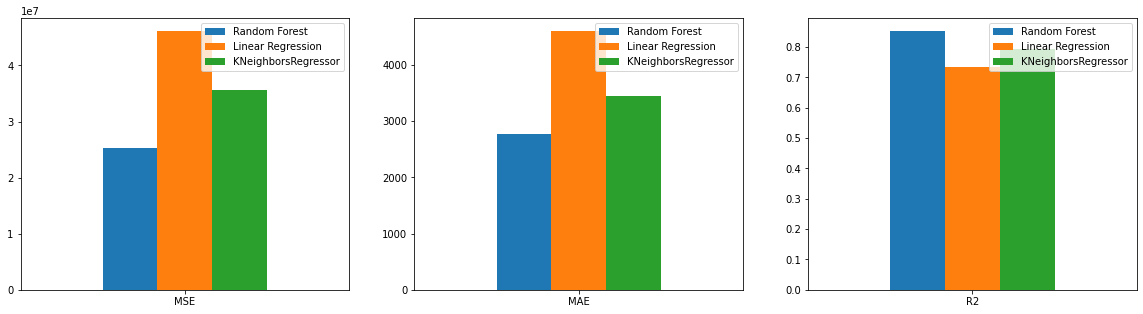

In [168]:
df_mse = pd.DataFrame({'Random Forest': RF_mse, 'Linear Regression': LR_mse, 'KNeighborsRegressor': KNR_mse}, index=['MSE'])
df_mae = pd.DataFrame({'Random Forest': RF_mae, 'Linear Regression': LR_mae, 'KNeighborsRegressor': KNR_mae}, index=['MAE'])
df_r2 = pd.DataFrame({'Random Forest': RF_r2, 'Linear Regression': LR_r2, 'KNeighborsRegressor': KNR_r2}, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])

plt.show()

From the above graphs we can make some observations:
- These tests confirms that `Random Forest` is the better regression model with a much lower MSE and MAE and higher R2 than the other models.
- `KNN` performed second best across these metrics, with only a slight drop in R2 between `Random Forest` and `kNN`.
- The worst performing model is the `Linear Regression` model, with the lowest R2 and the worst MSE & MAE scores


From these results, we have identified that Random Forest is the best performing model, and so we will choose this model to train

## Train Final Model

Finally, we can train a Random Forest regression model with all the data we have, assuming that the more data we have the better the model.

In [170]:
# function to remove the string 'regresson__' from the names of the best parameters
def transform(dict, prefix):
    dict_prefix = {key:value for key,value in dict.items() if prefix in key}
    return {key.replace(prefix,''):value for key,value in dict_prefix.items()}

pipe = make_pipeline(preprocess_pipeline, 
                     RF_best_params.get('reduce_dim'),
                     RandomForestRegressor(n_estimators=10, **transform(RF_best_params, 'regresson__')))

final_model =pipe.fit(X, y)

In [171]:
filename = 'final_model.sav'
pickle.dump(final_model, open(filename, 'wb'))

We can also store this model on disk.